In [74]:
%pylab inline
from scipy import integrate
from scipy.interpolate import CubicSpline,interp1d,UnivariateSpline
import matplotlib.gridspec as gridspec


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cond']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [75]:
## Standard definition 
nmu = 100
dmu = 1.0/nmu
mu = np.arange(0,1+dmu,dmu)

def Pl_0(x):
    return x*0+1

def Pl_2(x):
    return (3.0*x*x-1.0)*0.5

def Pl_4(x):
    return (35.0*x*x*x*x-30.0*x*x+3.0)*0.125

def Pl_6(x):
    return (231.0*x*x*x*x*x*x-315.0*x*x*x*x+105.0*x*x-5.0)*0.0625 

def Pl_8(x):
    return (6435.0*x*x*x*x*x*x*x*x-12012.0*x*x*x*x*x*x+6930.0*x*x*x*x-1260.0*x*x+35.0)/128.0

def Pl(x,l):
    if l==0:
        return Pl_0(x)
    if l==2:
        return Pl_2(x)
    if l==4:
        return Pl_4(x)
    if l==6:
        return Pl_6(x)
    if l==8:
        return Pl_8(x)
    
    
def expand(x):
    L0 = Pl(mu,0)
    L2 = Pl(mu,2)
    L4 = Pl(mu,4)
    L6 = Pl(mu,6)
    L8 = Pl(mu,8)
    sum = L0[None,:]*x[:,0][:,None]
    sum += L2[None,:]*x[:,1][:,None]
    sum += L4[None,:]*x[:,2][:,None]
    sum += L6[None,:]*x[:,3][:,None]
    sum += L8[None,:]*x[:,4][:,None]
    return sum

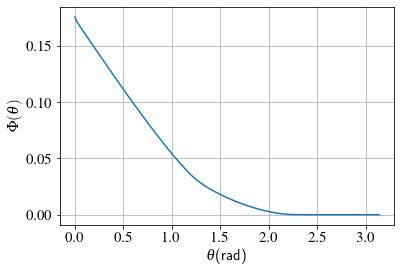

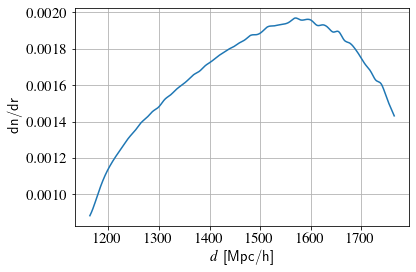

In [76]:
## Input for compute_AMF_kernel.c
## The code takes as input the survey angular correlation function and the radial selection function (dn/dr)
## Plot the survey angular correlation function calculated with Polspice

theta,wtheta = np.loadtxt("./data/boss_map_nside16384_partial_trim.cor",usecols=(0,2),unpack=True)

wtheta = wtheta[np.argsort(theta)]
theta = theta[np.argsort(theta)]

plt.plot(theta,wtheta)
plt.xlabel(r"$\theta$(rad)",fontsize=15)
plt.ylabel(r"$\Phi(\theta)$",fontsize=15)
plt.grid()
plt.show()


## Plot the radial selection function
## Computed in bins of size dz = 0.05 and smooth with a cubic spline (It has to be the exact radial range)

d,dndr = np.loadtxt("./data/finalspline_withMYfkp.dat",unpack=True)
plt.plot(d,dndr)
plt.xlabel(r"$d$ [Mpc/h]",fontsize=15)
plt.ylabel(r"dn/dr",fontsize=15)
plt.grid()
plt.show()


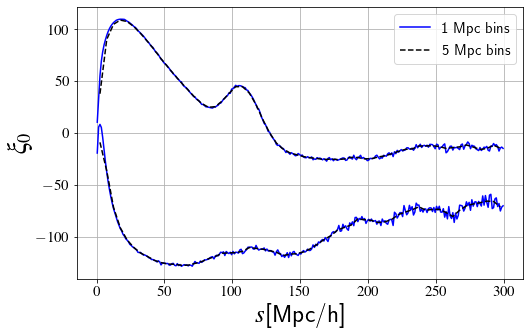

In [91]:
## For each mock, we measured AMF and standard xi(s,mu) in bins of size ds = 1 and dmu = 0.01.
## We then re-bin in size ds = 5 for cosmological constraints (i.e we fitted the 5Mpc bins multipoles)


## Load standard 2PCF

r,xi0,xi2,xi4,xi6,xi8 = np.loadtxt("./data/mean_xil_standard_NSERIES_1MPC.dat").T
xi0_1MPC = CubicSpline(r,xi0)
xi2_1MPC = CubicSpline(r,xi2)
xi4_1MPC = CubicSpline(r,xi4)
xi6_1MPC = CubicSpline(r,xi6)
xi8_1MPC = CubicSpline(r,xi8)

rr,xi0r,xi2r,xi4r,xi6r,xi8r = np.loadtxt("./data/mean_xil_standard_NSERIES_5MPC.dat").T
xi0_5MPC = CubicSpline(rr,xi0r)
xi2_5MPC = CubicSpline(rr,xi2r)
xi4_5MPC = CubicSpline(rr,xi4r)
xi6_5MPC = CubicSpline(rr,xi6r)
xi8_5MPC = CubicSpline(rr,xi8r)


## Plot of the monopole and quadrupole (quadrupole shifted for clarity)
## Note that 5 Mpc bins does not provided a good description of the low scales.

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(1, 1)
gs.update(hspace=0 ,wspace=0.2)


ax = fig.add_subplot(gs[0])
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Times']})
rc('text', usetex=True)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)


plt.plot(r,xi0*r**2,color="blue",label="1 Mpc bins")
plt.plot(rr,xi0r*rr**2,"--",color="black",label="5 Mpc bins")


plt.plot(r,xi2*r**2-40,color="blue")
plt.plot(rr,xi2r*rr**2-40,"--",color="black")

ax.set_ylabel(r"$ \xi_{0}$",fontsize=25)
ax.set_xlabel(r"$ s$[Mpc/h]",fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [64]:
## Load AMF multipoles 

rs,xi0s,xi2s,xi4s = np.loadtxt("./data/mean_xil_AMF_NSERIES_5MPC.dat").T

rss,xi0ss,xi2ss,xi4ss = np.loadtxt("./data/mean_xil_AMF_NSERIES_1MPC.dat").T

## Load RR pairscounts

smin,smax,R0,R1,R2,R3,R4,R5,R6,R7,R8 = np.loadtxt("./data/RR_CMASS_mid_suave_1e-15_legendre.txt").T

st = (smin + smax)/2.

## Load AMF kernels 
## Compute in bin size ddelta = 1 up to 500 Mpc/h.
kernels = np.loadtxt("./data/AMF_KERNELS_1MPC_CMASS_mid_suave_1e-15_legendre.txt").T

delta = (kernels[2]+kernels[3])/2.


In [92]:
## Reshape kernels into matrix given a maximum delta value.
## Note : We measured the multipoles up to 300 Mpc/h such that we cannot to higher delta_max.
## To integrate up to delta_max = 500 Mpc/h, extrapolate the measured multipoles with your bestfit model,
## or directly use your theoretical predictions in cosmological fits.
delta_max = 300.
cond = np.where(delta < delta_max)

kernels_cut = np.zeros((29,len(cond[0])))
for i in range(0,len(kernels[:,0])):
    kernels_cut[i] = kernels[i][cond]
            
            
smink,smaxk,deltamin,deltamax,W00,W02,W04,W06,W08,W20, \
W22,W24,W26,W28,W40,W42,W44,W46,W48,W60,W62,W64,W66,W68, \
W80,W82,W84,W86,W88= kernels_cut

sk = (smink + smaxk)/2.
dk = (deltamin + deltamax)/2.


sarray = np.unique(sk)
darray = np.unique(dk)


ds = sarray[1] - sarray[0]
dd = darray[1] - darray[0]

xi0t = xi0d(darray)
xi2t = xi2d(darray)
xi4t = xi4d(darray)
xi6t = xi6d(darray)
xi8t = xi8d(darray)

W00 = W00.reshape(len(sarray),len(darray))
W02 = W02.reshape(len(sarray),len(darray))
W04 = W04.reshape(len(sarray),len(darray))
W06 = W06.reshape(len(sarray),len(darray))
W08 = W08.reshape(len(sarray),len(darray))

W20 = W20.reshape(len(sarray),len(darray))
W22 = W22.reshape(len(sarray),len(darray))
W24 = W24.reshape(len(sarray),len(darray))
W26 = W26.reshape(len(sarray),len(darray))
W28 = W28.reshape(len(sarray),len(darray))

W40 = W40.reshape(len(sarray),len(darray))
W42 = W42.reshape(len(sarray),len(darray))
W44 = W44.reshape(len(sarray),len(darray))
W46 = W46.reshape(len(sarray),len(darray))
W48 = W48.reshape(len(sarray),len(darray))

W60 = W60.reshape(len(sarray),len(darray))
W62 = W62.reshape(len(sarray),len(darray))
W64 = W64.reshape(len(sarray),len(darray))
W66 = W66.reshape(len(sarray),len(darray))
W68 = W68.reshape(len(sarray),len(darray))

W80 = W80.reshape(len(sarray),len(darray))
W82 = W82.reshape(len(sarray),len(darray))
W84 = W84.reshape(len(sarray),len(darray))
W86 = W86.reshape(len(sarray),len(darray))
W88 = W88.reshape(len(sarray),len(darray))

In [51]:
## Compute AMF multipoles
## Riemmann integral along delta (by using the 1 Mpc)
## For cosmological constraints, replace the measured multipoles by your theoritical redshift-space distortions multipoles.

W0 = W00*xi0t + W02*xi2t + W04*xi4t + W06*xi6t + W08*xi8t
W0 = np.sum(W0,axis=1)*dd*1./2.

W2 = W20*xi0t + W22*xi2t + W24*xi4t + W26*xi6t + W28*xi8t
W2 = np.sum(W2,axis=1)*dd*5./2.

W4 = W40*xi0t + W42*xi2t + W44*xi4t + W46*xi6t + W48*xi8t
W4 = np.sum(W4,axis=1)*dd*9./2.

W6 = W60*xi0t + W62*xi2t + W64*xi4t + W66*xi6t + W68*xi8t
W6 = np.sum(W6,axis=1)*dd*13./2.

W8 = W80*xi0t + W82*xi2t + W84*xi4t + W86*xi6t + W88*xi8t
W8 = np.sum(W8,axis=1)*dd*17./2.

Wl = np.vstack([W0,W2,W4,W6,W8]).T
RRl= np.vstack([R0,R2,R4,R6,R8]).T

RRsmu = expand(RRl)
Wlsmu = expand(Wl)

        
kernels_final = Wlsmu/RRsmu

## Analytical RR estimations allows exact mu integration from 0 to 1.

res0 = 2*integrate.simps(kernels_final,mu)*1./2
res2 = 2*integrate.simps(kernels_final*Pl(mu,2),mu)*5./2.
res4 = 2*integrate.simps(kernels_final*Pl(mu,4),mu)*9./2.
res6 = 2*integrate.simps(kernels_final*Pl(mu,6),mu)*13./2.
res8 = 2*integrate.simps(kernels_final*Pl(mu,8),mu)*17./2.


## Final multipoles
## Note : By changing the input xi_standard, it will change the modelled AMF low-scale. (This won't matter when
## using RSD predictions instead)
xi0_AMF = xi0_5MPC(sarray) + res0
xi2_AMF = xi2_5MPC(sarray) + res2
xi4_AMF = xi4_5MPC(sarray) + res4


xi0_AMF_v2 = xi0_1MPC(sarray) + res0
xi2_AMF_v2 = xi2_1MPC(sarray) + res2
xi4_AMF_v2 = xi4_1MPC(sarray) + res4

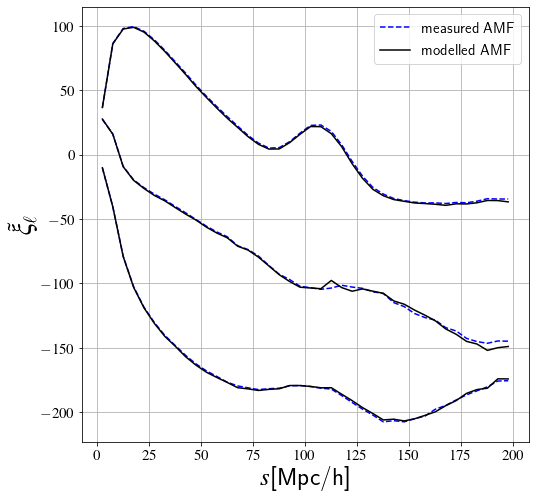

In [50]:
## Plot results (quadrupole and hexadecapole are shifted for clarity)
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
gs.update(hspace=0 ,wspace=0.2)


ax = fig.add_subplot(gs[0])
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Times']})
rc('text', usetex=True)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)

ax.plot(rs,xi0s*rs**2,"--",color="blue",label="measured AMF")
ax.plot(rs,xi0_AMF*rs**2,color="black",label="modelled AMF")

ax.plot(rs,xi2s*rs**2-40.,"--",color="blue")
ax.plot(rs,xi2_AMF*rs**2-40.,color="black")

ax.plot(rs,xi4s*rs**2-20.,"--",color="blue")
ax.plot(rs,xi4_AMF*rs**2-20.,color="black")

ax.set_ylabel(r"$ \tilde{\xi}_{\ell}$",fontsize=25)
ax.set_xlabel(r"$ s$[Mpc/h]",fontsize=25)

ax.legend(fontsize=15)
ax.grid()

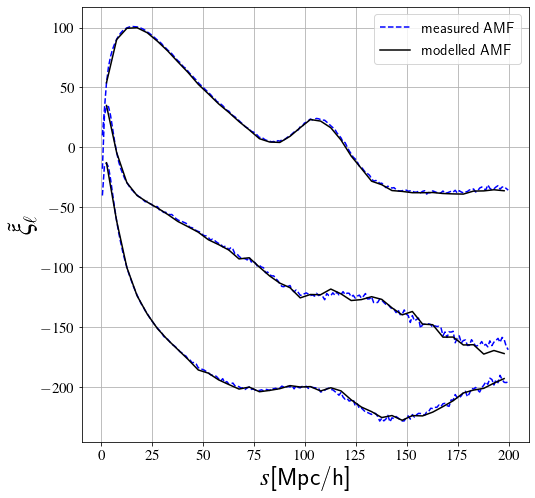

In [57]:
## Plot results (quadrupole and hexadecapole are shifted for clarity)
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
gs.update(hspace=0 ,wspace=0.2)


ax = fig.add_subplot(gs[0])
rc('font',**{'family':'serif','serif':['Times']})
rc('font',**{'family':'sans-serif','sans-serif':['Times']})
rc('text', usetex=True)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)

ax.plot(rss,xi0ss*rss**2,"--",color="blue",label="measured AMF")
ax.plot(rs,xi0_AMF_v2*rs**2,color="black",label="modelled AMF")

ax.plot(rss,xi2ss*rss**2-60.,"--",color="blue")
ax.plot(rs,xi2_AMF_v2*rs**2-60.,color="black")

ax.plot(rss,xi4ss*rss**2-40.,"--",color="blue")
ax.plot(rs,xi4_AMF_v2*rs**2-40.,color="black")

ax.set_ylabel(r"$ \tilde{\xi}_{\ell}$",fontsize=25)
ax.set_xlabel(r"$ s$[Mpc/h]",fontsize=25)

ax.legend(fontsize=15)
ax.grid()